# Using a Pre-Trained Conv-net

Lets have plots appear inline:

In [1]:
%matplotlib inline

We're going to need `os`, `numpy`, `matplotlib`, `skimage`, `theano` and `lasagne`. The `pretrained_vgg_models` contains some useful functions for building and acquiring VGG models. We also want to import some layer classes and utilities from Lasagne for convenience.

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
import skimage
import theano
import lasagne
import pretrained_vgg_models

from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer, DropoutLayer, Pool2DLayer, Conv2DLayer
from lasagne.nonlinearities import softmax
from lasagne.utils import floatX


/Users/Geoff/packages/Theano/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


## Load an image to classify

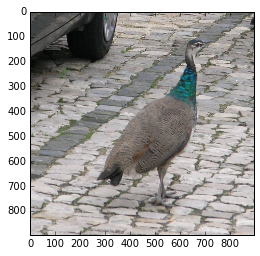

In [3]:
IMAGE_PATH = os.path.join('images', 'P1013781.JPG')
# Extract a 896 x 896 block surrounding the peacock
img = plt.imread(IMAGE_PATH)[1800:2696,652:1548]
plt.imshow(img)
plt.show()

## Load the 19-layer VGG-19 model parameters

The `pretrained_vgg_models.vgg19_params` function load a `pickle` file containing the VGG-19 network parameters from the path `pretrained_models/vgg19.pkl`. If that file does not exist, it will download it from http://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg19.pkl.

In [4]:
vgg19_params = pretrained_vgg_models.VGG19Model.load_params()

Lets take a look at what we got:

In [5]:
# It should be a `dict`
assert type(vgg19_params) == dict
# Print the dictionary keys:
print(vgg19_params.keys())

['mean value', 'synset words', 'model name', 'param values']


Our network parameters come in the form of a `dict`. It is layed out as follows:

`vgg19_params['mean value']` is a 3-element array giving the mean pixel value in RGB. This must be subtracted from every pixel in an image before passing it to the network for classification.

`vgg19_params['synset words']` is a list of strings that provide the names of the classes. This way, we can use the model to classify an image, resulting in an integer class number, which we can name using this list.

`vgg19_params['model name']` is the name of the model.

`vgg19_params['param values']` contains a list of numpy arrays that provide the network parameters (weights and biases).

In [6]:
print('Mean value = {}'.format(vgg19_params['mean value']))
print('')
print('First 5 class names:')
for i, name in enumerate(vgg19_params['synset words'][:5]):
    print('{}. {}'.format(i, name))
print('')
print('Model name = {}'.format(vgg19_params['model name']))

Mean value = [ 103.939  116.779  123.68 ]

First 5 class names:
0. tench, Tinca tinca
1. goldfish, Carassius auratus
2. great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
3. tiger shark, Galeocerdo cuvieri
4. hammerhead, hammerhead shark

Model name = VGG-19


## Build the network

Now we will use the Lasagne API to build the VGG-19 network architecture.

### The architecture
VGG networks consist of convolutional layers that use 3x3 convolutional kernels and pad the input to ensure that the output size remains the same as the input size. Since a 3x3 convolution will reduce the size of the image by two pixels, this means that the image must be zero-padded by 1 pixel at each side.

#### A note about processing images with conv-nets in Theano

Convolutional networks in Theano expect images to come in the form of 4-dimensional arrays rather than 3-dimensional ones. The dimensions are: `(sample, channel, height, width)`. The `sample` dimension allows you to stack a number of images in a mini-batch so that you can predict (or train) a number of images in one go. The `channel` dimension divides an image into one plane per channel, where channels are R, G and B for the input or more complex representations corresponding to filters further down the network. The `height` and `width` dimensions are the `Y` and `X` axes of the image.

For example: to store 128 RGB images of 224 x 224, you would need an array of size `(128, 3, 224, 224)`.


In [7]:
def build_vgg19_network():
    net = {}
    # Input layer: shape is of the form (sample, channel, height, width).
    # We are using 3 channel images of size 224 x 224.
    # We leave the sample dimension with no size (`None`) so that the
    # minibatch size is whatever we need it to be when we use it
    net['input'] = InputLayer((None, 3, 224, 224))
    
    # First two convolutional layers: 64 filters, 3x3 convolution, 1 pixel padding
    # flip_filters is on because we are using a network imported from Caffe
    net['conv1_1'] = Conv2DLayer(net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = Conv2DLayer(net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    # 2x2 max-pooling; will reduce size from 224x224 to 112x112
    net['pool1'] = Pool2DLayer(net['conv1_2'], 2)
    
    # Two convolutional layers, 128 filters
    net['conv2_1'] = Conv2DLayer(net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = Conv2DLayer(net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    # 2x2 max-pooling; will reduce size from 112x112 to 56x56
    net['pool2'] = Pool2DLayer(net['conv2_2'], 2)
    
    # Four convolutional layers, 256 filters
    net['conv3_1'] = Conv2DLayer(net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = Conv2DLayer(net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = Conv2DLayer(net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_4'] = Conv2DLayer(net['conv3_3'], 256, 3, pad=1, flip_filters=False)
    # 2x2 max-pooling; will reduce size from 56x56 to 28x28
    net['pool3'] = Pool2DLayer(net['conv3_4'], 2)
    
    # Four convolutional layers, 512 filters
    net['conv4_1'] = Conv2DLayer(net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = Conv2DLayer(net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = Conv2DLayer(net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['conv4_4'] = Conv2DLayer(net['conv4_3'], 512, 3, pad=1, flip_filters=False)
    # 2x2 max-pooling; will reduce size from 28x28 to 14x14
    net['pool4'] = Pool2DLayer(net['conv4_4'], 2)
    
    # Four convolutional layers, 512 filters
    net['conv5_1'] = Conv2DLayer(net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = Conv2DLayer(net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = Conv2DLayer(net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['conv5_4'] = Conv2DLayer(net['conv5_3'], 512, 3, pad=1, flip_filters=False)
    # 2x2 max-pooling; will reduce size from 14x14 to 7x7
    net['pool5'] = Pool2DLayer(net['conv5_4'], 2)
    
    # Dense layer, 4096 units
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    # 50% dropout (only applied during training, turned off during prediction)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    
    # Dense layer, 4096 units
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
    # 50% dropout (only applied during training, turned off during prediction)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
    
    # Final dense layer, 1000 units: 1 for each class
    net['fc8'] = DenseLayer(net['fc7_dropout'], num_units=1000, nonlinearity=None)
    # Softmax non-linearity that will generate probabilities
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)

    return net

In [8]:
# Build it
vgg19_net = build_vgg19_network()

## Load parameters into the network

Now we must load the parameters that we loaded earlier into our network. The Lasagne helper function `lasagne.layers.set_all_param_values` will do this for us. Given the last layer, it will find all the layers in the network in order and assign them parameters from a list of numpy arrays, such as the `'param values'` list.

In [9]:
lasagne.layers.set_all_param_values(vgg19_net['prob'], vgg19_params['param values'])

## Set up Theano variables and expressions for classification

We use the Theano API to build a symbolic representation of the mathematical expressions that we wish to evaluate.

We need a variable that will represent the values that we use as input, in this case an image. Recall earlier that Theano conv-nets take images in the form of 4-dimensional arrays. We construct a 4D variable using `theano.tensor.tensor4`, giving it the name `'x'`.

In [10]:
in_var = theano.tensor.tensor4('x')

Lasagne will take care of preparing the Theano expressions that form the network. We use its `lasagne.layers.get_output` function to generate the expression that will evaluate the network. We want the output of the layer named `'prob'`. We use the input variable constructed above to provide the input. `deterministic=True` will cause the dropout layers to be switched off; this is what we want during prediction as dropout is only used during training.

In [11]:
prob_expr = lasagne.layers.get_output(vgg19_net['prob'], in_var, deterministic=True)

Now we build a Theano function that will return the result of evaluating the network given a batch of images as input.

In [12]:
prob_fn = theano.function([in_var], prob_expr)

## Preparing the image for classification

There are a few transformations we must perform on the image to get it into a form that VGG-net can operate on:

- we must scale and crop the image to 224x224, as this is the size that VGG net expects
- VGG networks expect image channels to have BGR order, our images are RGB so the order of the channel axis must be flipped
- subtract the image mean supplied by the network parameters
- ensure that the axes are `(sample, channel, height, width)`

In [13]:
def vgg_prepare_image(im, image_mean, image_size=224):
    # If the image is greyscale, convert it to RGB
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
        
    # Scale the image so that its smallest dimension is the desired size
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (image_size, w * image_size / h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h * image_size / w, image_size), preserve_range=True)

    # Crop the central `image_size` x `image_size` region of the image
    h, w, _ = im.shape
    im = im[h//2 - image_size // 2:h // 2 + image_size // 2, w // 2 - image_size // 2:w // 2 + image_size // 2]

    # Convert to uint8 type
    rawim = np.copy(im).astype('uint8')

    # Shuffle axes from (height, width, channel) to (channel, height, width)
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)

    # Images come in RGB channel order, while VGG net expects BGR:
    im = im[::-1, :, :]
    
    # If necessary, add 2 axes to the mean so that it will broadcast when we subtract
    # it from the image
    if len(image_mean.shape) == 1:
        image_mean = image_mean[:,None,None]

    # Subtract the mean
    im = im - image_mean
    
    # Add the sample axis to the image; (channel, height, width) -> (sample, channel, height, width)
    im = im[np.newaxis]
    
    return rawim, floatX(im)

Transform the image:

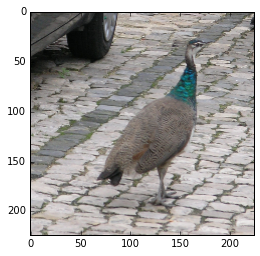

In [14]:
raw_img, img_for_vgg = vgg_prepare_image(img, image_mean=vgg19_params['mean value'])
plt.imshow(raw_img)
plt.show()

Run the image through the network, generating a matrix of probabilities; each row of the matrix represents the probabilities of the corresponding image from the batch.

In [15]:
pred_prob = prob_fn(img_for_vgg)

print(pred_prob.shape)

(1, 1000)


Use `np.argmax` to get the index of the class with the maximum probability:

In [16]:
pred_cls = np.argmax(pred_prob, axis=1)
print('Predicted class index {} with probability {:.2f}%, named "{}"'.format(
    pred_cls[0], pred_prob[0, pred_cls[0]]*100.0, vgg19_params['synset words'][pred_cls[0]]))

Predicted class index 84 with probability 98.99%, named "peacock"
